# Logistic Regression

In [1]:
# !pip install imblearn

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import RandomOverSampler#, SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from src import log_reg_utils

## UDF

## Import Dataset

In [4]:
accidents = pd.read_csv('data/accidents.csv', index_col=0)
for idx, feature in enumerate(accidents.columns):
    print('{}. {}'.format(idx, feature))

0. POSTED_SPEED_LIMIT
1. TRAFFIC_CONTROL_DEVICE
2. DEVICE_CONDITION
3. WEATHER_CONDITION
4. LIGHTING_CONDITION
5. FIRST_CRASH_TYPE
6. TRAFFICWAY_TYPE
7. ALIGNMENT
8. ROADWAY_SURFACE_COND
9. ROAD_DEFECT
10. CRASH_TYPE
11. INTERSECTION_RELATED_I
12. NOT_RIGHT_OF_WAY_I
13. PRIM_CONTRIBUTORY_CAUSE
14. INJURIES_UNKNOWN
15. CRASH_HOUR
16. CRASH_DAY_OF_WEEK
17. CRASH_MONTH
18. crash_date
19. crash_month
20. is_fatal_or_incap
21. time_of_day
22. is_weekend
23. season
24. is_no_sunlight
25. is_cyclist
26. is_pedestrian
27. is_head_on
28. is_parked
29. is_using_cellphone
30. has_disregarded_traffic_devices
31. is_failed_to_yield_right_of_way
32. is_reckless_driving
33. is_improper_backing
34. is_intersection_related_involve
35. is_not_right_of_way_involve
36. is_sleet_snow
37. is_rain
38. is_clear_weather
39. is_dark_has_no_lighting
40. has_stop_sign_or_traffic_light
41. is_intersection
42. has_snow_ice_on_road
43. is_non_functioning_device
44. has_no_controls
45. has_no_physical_divider
46. is_

## Process Data for Model

In [25]:
indices = [26, 28, 38, 0, 44, 45, 25, 27, 39, 42, 24, 33, 34, 30]
selected_features = list(accidents.columns[indices])

X = accidents[selected_features]
y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [26]:
#scaler = MinMaxScaler()
scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
oversampler = RandomOverSampler(sampling_strategy=0.75, random_state=3)
#oversampler = SMOTE(sampling_strategy=0.75, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train_scaled, y_train)

### Hyperparameter Tuning

In [28]:
#solvers = ['saga', 'newton-cg', 'lbfgs', 'liblinear']
#penalties = ['l1', 'l2']
c_values =  [0.01, 0.1, 1.0, 10, 100]
params_grid = dict(C=c_values)#, penalty=penalties, solver=solvers)

In [29]:
log_reg = LogisticRegression(max_iter=1000, fit_intercept=True, random_state=3)

clf = GridSearchCV(log_reg, params_grid, cv=5, verbose=0, scoring='recall')

best_model = clf.fit(X_over, y_over)

In [30]:
print('Best Solver: ', best_model.best_estimator_.get_params()['solver'])
print('Optimal Penalty: ', best_model.best_estimator_.get_params()['penalty'])
print('Best C: ', best_model.best_estimator_.get_params()['C'])

Best Solver:  lbfgs
Optimal Penalty:  l2
Best C:  1.0


In [23]:
params_grid

{'C': [0.01, 0.1, 1.0, 10, 100]}

### Train and Predict

In [31]:
penalty = 'l2'
solver='lbfgs'
c=1.0

log_reg = LogisticRegression(penalty=penalty, solver=solver, C=c, max_iter=1000, fit_intercept=True, random_state=3)
log_reg.fit(X_over, y_over)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[51250  6300]
 [  548   517]]


Recall (Scores FN):  0.4854
Precision (Scores FP):  0.0758
AUC Score:  0.7683


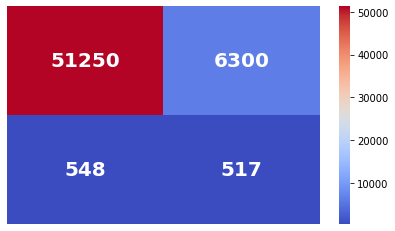

In [33]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

In [34]:
coef_summary = pd.DataFrame()
coef_summary['feature_name'] = pd.Series(X.columns)
coef_summary['log_reg_coef'] = pd.Series(log_reg.coef_[0])
coef_summary.sort_values('log_reg_coef', inplace = True, ascending=False)
coef_summary.to_csv('img/log_reg_coeffs.jpg')
coef_summary


,feature_name,log_reg_coef
0,is_pedestrian,0.457594
12,is_intersection_related_involve,0.273408
3,POSTED_SPEED_LIMIT,0.259760
6,is_cyclist,0.258531
10,is_no_sunlight,0.231144
13,has_disregarded_traffic_devices,0.163725
7,is_head_on,0.127806
4,has_no_controls,0.114188
2,is_clear_weather,0.016821
5,has_no_physical_divider,-0.015807


In [35]:
print('Intercept: ', log_reg.intercept_[0])

Intercept:  -0.7928801811472641


### Test for Multicolinearity

In [36]:
X_over_incl_const = sm.add_constant(X_over)
model = sm.Logit(y_over, X_over_incl_const)
results = model.fit(method='lbfgs')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      is_fatal_or_incap   No. Observations:               402531
Model:                          Logit   Df Residuals:                   402516
Method:                           MLE   Df Model:                           14
Date:                Wed, 03 Feb 2021   Pseudo R-squ.:                  0.1919
Time:                        23:47:39   Log-Likelihood:            -2.2214e+05
converged:                       True   LL-Null:                   -2.7489e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7929      0.004   -190.717      0.000      -0.801      -0.785
x1             0.4576      0.003    179.205      0.000       0.453       0.463
x2            -0.3017      0.005    -59.763      0.000      -0.312      -0.292
x3             0.0168      0.004      4.374      0.000       0.009       0.024
x4             0.2598      0.005     56.717      0.000       0.251       0.269
x5             0.1142      0.004     25.996      0.000       0.106       0.123
x6            -0.0158      0.004     -4.207      0.000      -0.023      -0.008
x7             0.2585      0.002    103.599      0.000       0.254       0.263
x8             0.1278      0.003     46.712      0.000       0.122       0.133
x9            -0.0779      0.004    -19.678      0.000      -0.086      -0.070
x10           -0.0603      0.004    -14.347      0.000      -0.069      -0.052
x11            0.2311      0.004     65.368      0.000       0.224       0.238
x12           -0.3078      0.007    -44.660      0.000      -0.321      -0.294
x13            0.2734      0.004     69.970      0.000       0.266       0.281
x14            0.1637      0.003     57.538      0.000       0.158       0.169
==============================================================================
"""

In [37]:
X_over_df = pd.DataFrame(X_over, columns=X.columns)
log_reg_utils.calc_vif(X_over_df)

,features,VIF
0,is_pedestrian,1.062400
1,is_parked,1.249255
2,is_clear_weather,1.084149
3,POSTED_SPEED_LIMIT,1.101357
4,has_no_controls,1.490645
5,has_no_physical_divider,1.052365
6,is_cyclist,1.025883
7,is_head_on,1.012913
8,is_dark_has_no_lighting,1.035274
9,has_snow_ice_on_road,1.082690
